# <font size="7"> **Assignment-7**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [2]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 5

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

# Data generation

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


Training Set: torch.Size([2100, 2]), Validation Set: torch.Size([900, 2])
Layer 1 : W torch.Size([2, 16]), b torch.Size([16])
Layer 2 : W torch.Size([16, 16]), b torch.Size([16])
Layer 3 : W torch.Size([16, 16]), b torch.Size([16])
Layer 4 : W torch.Size([16, 1]), b torch.Size([1])


/tmp/ipython-input-3955932552.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipython-input-3955932552.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


Epoch  50/300 | Train Loss: 0.6514 | Val Loss: 0.6444 | Train Acc: 0.6010 | Val Acc: 0.6167
Epoch 100/300 | Train Loss: 0.6471 | Val Loss: 0.6410 | Train Acc: 0.6010 | Val Acc: 0.6167
Epoch 150/300 | Train Loss: 0.6444 | Val Loss: 0.6386 | Train Acc: 0.5986 | Val Acc: 0.6156
Epoch 200/300 | Train Loss: 0.6422 | Val Loss: 0.6366 | Train Acc: 0.5971 | Val Acc: 0.6122
Epoch 250/300 | Train Loss: 0.6402 | Val Loss: 0.6347 | Train Acc: 0.5938 | Val Acc: 0.6111
Epoch 300/300 | Train Loss: 0.6385 | Val Loss: 0.6332 | Train Acc: 0.5876 | Val Acc: 0.6044
Training Accuracy:   0.5876
Validation Accuracy: 0.6044
Training Loss:       0.6385
Validation Loss:     0.6332


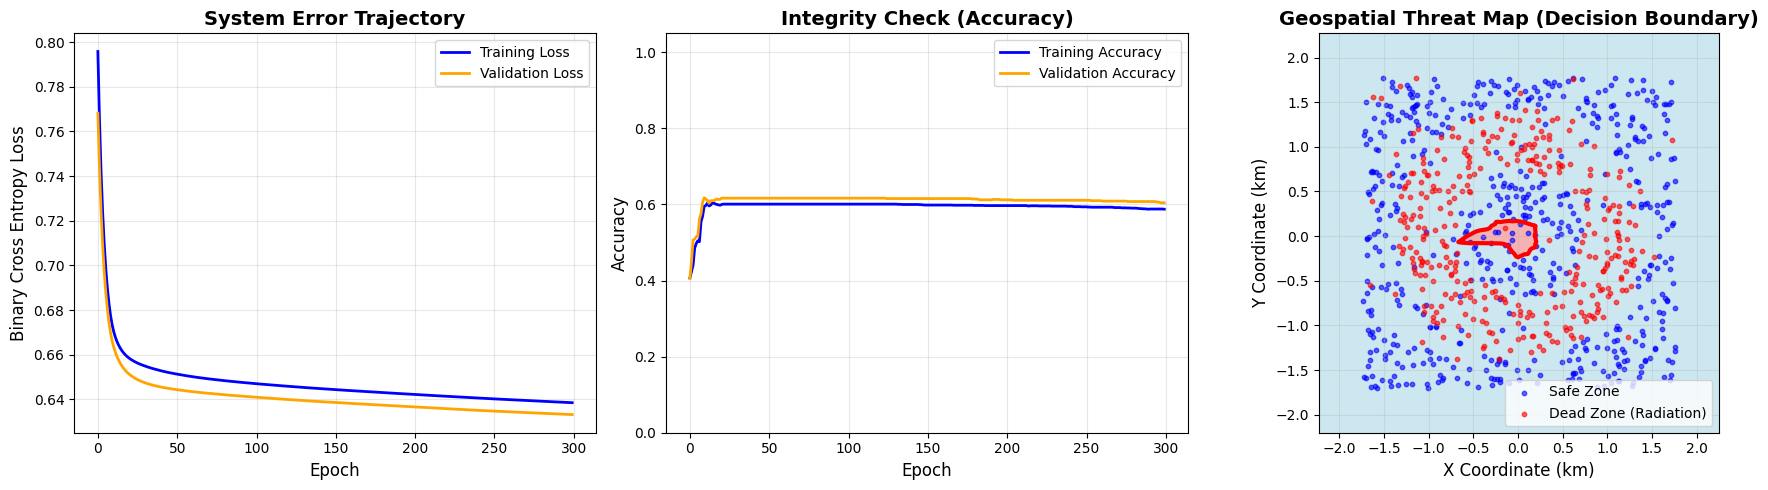

In [12]:
# ==============================================================================
# Code from here. Best of luckk :)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42
)
print(f"Training Set: {X_train.shape}, Validation Set: {X_test.shape}")

LEARNING_RATE = 0.01
EPOCHS = 300
HIDDEN_NEURONS = 16


# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Convert to tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# initializing weights
torch.manual_seed(GROUP_NUMBER)
w1 = torch.randn(2, HIDDEN_NEURONS, requires_grad=True)
w1.data *= np.sqrt(2.0 / 2)
b1 = torch.zeros(HIDDEN_NEURONS, requires_grad=True)

w2 = torch.randn(HIDDEN_NEURONS, HIDDEN_NEURONS, requires_grad=True)
w2.data *= np.sqrt(2.0 / HIDDEN_NEURONS)
b2 = torch.zeros(HIDDEN_NEURONS, requires_grad=True)

w3 = torch.randn(HIDDEN_NEURONS, HIDDEN_NEURONS, requires_grad=True)
w3.data *= np.sqrt(2.0 / HIDDEN_NEURONS)
b3 = torch.zeros(HIDDEN_NEURONS, requires_grad=True)

w4 = torch.randn(HIDDEN_NEURONS, 1, requires_grad=True)
w4.data *= np.sqrt(2.0 / HIDDEN_NEURONS)
b4 = torch.zeros(1, requires_grad=True)

print(f"Layer 1 : W {w1.shape}, b {b1.shape}")
print(f"Layer 2 : W {w2.shape}, b {b2.shape}")
print(f"Layer 3 : W {w3.shape}, b {b3.shape}")
print(f"Layer 4 : W {w4.shape}, b {b4.shape}")


# Training Loop

train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(EPOCHS):
    #  Forward Pass
    z1 = torch.matmul(X_train, w1) + b1
    a1 = torch.relu(z1)
    z2 = torch.matmul(a1, w2) + b2
    a2 = torch.relu(z2)
    z3 = torch.matmul(a2, w3) + b3
    a3 = torch.relu(z3)
    z4 = torch.matmul(a3, w4) + b4
    a4 = torch.sigmoid(z4)

    train_pred = torch.clamp(a4, 1e-7, 1 - 1e-7)
    loss = -(y_train*torch.log(train_pred) + (1-y_train)*torch.log(1-train_pred)).mean()
    train_losses.append(loss.item())

    binary_preds = (train_pred >= 0.5).float()
    correct = (binary_preds == y_train).sum().item()
    train_acc.append(correct / len(y_train))

    # Backprop
    loss.backward()
    with torch.no_grad():
        w1 -= LEARNING_RATE * w1.grad
        b1 -= LEARNING_RATE * b1.grad
        w2 -= LEARNING_RATE * w2.grad
        b2 -= LEARNING_RATE * b2.grad
        w3 -= LEARNING_RATE * w3.grad
        b3 -= LEARNING_RATE * b3.grad
        w4 -= LEARNING_RATE * w4.grad
        b4 -= LEARNING_RATE * b4.grad
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()
        w3.grad.zero_()
        b3.grad.zero_()
        w4.grad.zero_()
        b4.grad.zero_()

    # Validation
    z1_val = torch.matmul(X_test, w1) + b1
    a1_val = torch.relu(z1_val)
    z2_val = torch.matmul(a1_val, w2) + b2
    a2_val = torch.relu(z2_val)
    z3_val = torch.matmul(a2_val, w3) + b3
    a3_val = torch.relu(z3_val)
    z4_val = torch.matmul(a3_val, w4) + b4
    a4_val = torch.sigmoid(z4_val)

    val_pred = torch.clamp(a4_val, 1e-7, 1 - 1e-7)
    val_loss = -(y_test*torch.log(val_pred) + (1-y_test)*torch.log(1-val_pred)).mean()
    val_losses.append(val_loss.item())

    binary_preds_val = (val_pred >= 0.5).float()
    correct_val = (binary_preds_val == y_test).sum().item()
    val_acc.append(correct_val / len(y_test))

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | "
              f"Train Acc: {train_acc[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")


# # activation functions
# def relu(x):
#     return torch.clamp(x, min=0)

# def sigmoid(x):
#     return 1 / (1 + torch.exp(-x))

# # forward pass

# def forward(X):
#     z1 = X @ W1 + b1
#     a1 = relu(z1)

#     z2 = a1 @ W2 + b2
#     a2 = relu(z2)

#     z3 = a2 @ W3 + b3
#     a3 = relu(z3)

#     z4 = a3 @ W4 + b4
#     y_hat = sigmoid(z4)

#     return y_hat

# # binary cross entropy
# def bce_loss(y_hat, y):
#     eps = 1e-7
#     y_hat = torch.clamp(y_hat, eps, 1 - eps)
#     loss = -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
#     return loss.mean()


# # accuracy
# def accuracy(y_hat, y):
#     preds = (y_hat >= 0.5).float()
#     return (preds == y).float().mean()

# Final Metrics

final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]

print(f"Training Accuracy:   {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss:       {final_train_loss:.4f}")
print(f"Validation Loss:     {final_val_loss:.4f}")

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  Loss Curve
axes[0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Binary Cross Entropy Loss', fontsize=12)
axes[0].set_title('System Error Trajectory', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

#  Accuracy Curve
axes[1].plot(train_acc, label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(val_acc, label='Validation Accuracy', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Integrity Check (Accuracy)', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1.05])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Decision Boundary
ax3 = axes[2]
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Manual forward pass on grid points
with torch.no_grad():
    z1_g = torch.matmul(grid_tensor, w1) + b1
    a1_g = torch.relu(z1_g)
    z2_g = torch.matmul(a1_g, w2) + b2
    a2_g = torch.relu(z2_g)
    z3_g = torch.matmul(a2_g, w3) + b3
    a3_g = torch.relu(z3_g)
    z4_g = torch.matmul(a3_g, w4) + b4
    a4_g = torch.sigmoid(z4_g)
    grid_predictions = a4_g.numpy().reshape(xx.shape)

# Contour plot
contours = ax3.contour(xx, yy, grid_predictions, levels=[0.5], colors='red', linewidths=3)
contourf = ax3.contourf(xx, yy, grid_predictions, levels=[0, 0.5, 1], colors=['lightblue', 'lightcoral'], alpha=0.6)

# Overlay test points
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()
ax3.scatter(X_test_np[y_test_np.flatten()==0, 0], X_test_np[y_test_np.flatten()==0, 1],
            c='blue', s=10, label='Safe Zone', alpha=0.6)
ax3.scatter(X_test_np[y_test_np.flatten()==1, 0], X_test_np[y_test_np.flatten()==1, 1],
            c='red', s=10, label='Dead Zone (Radiation)', alpha=0.6)

ax3.set_xlabel('X Coordinate (km)', fontsize=12)
ax3.set_ylabel('Y Coordinate (km)', fontsize=12)
ax3.set_title('Geospatial Threat Map (Decision Boundary)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

plt.tight_layout()
plt.savefig('GDC_Dashboard_Group5', dpi=150, bbox_inches='tight')
plt.show()

# ==============================================================================

In above cell we have used relu activation function.
In below cell we have used tanh activation function.


Training Set: torch.Size([2100, 2]), Validation Set: torch.Size([900, 2])
Layer 1 : W torch.Size([2, 16]), b torch.Size([16])
Layer 2 : W torch.Size([16, 16]), b torch.Size([16])
Layer 3 : W torch.Size([16, 16]), b torch.Size([16])
Layer 4 : W torch.Size([16, 1]), b torch.Size([1])


/tmp/ipython-input-2188061411.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipython-input-2188061411.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


Epoch  50/300 | Train Loss: 0.6860 | Val Loss: 0.6870 | Train Acc: 0.5643 | Val Acc: 0.5622
Epoch 100/300 | Train Loss: 0.6803 | Val Loss: 0.6802 | Train Acc: 0.5743 | Val Acc: 0.5878
Epoch 150/300 | Train Loss: 0.6780 | Val Loss: 0.6771 | Train Acc: 0.5924 | Val Acc: 0.6011
Epoch 200/300 | Train Loss: 0.6766 | Val Loss: 0.6753 | Train Acc: 0.5933 | Val Acc: 0.6089
Epoch 250/300 | Train Loss: 0.6754 | Val Loss: 0.6739 | Train Acc: 0.5914 | Val Acc: 0.6089
Epoch 300/300 | Train Loss: 0.6744 | Val Loss: 0.6728 | Train Acc: 0.5886 | Val Acc: 0.6078
Training Accuracy:   0.5886
Validation Accuracy: 0.6078
Training Loss:       0.6744
Validation Loss:     0.6728


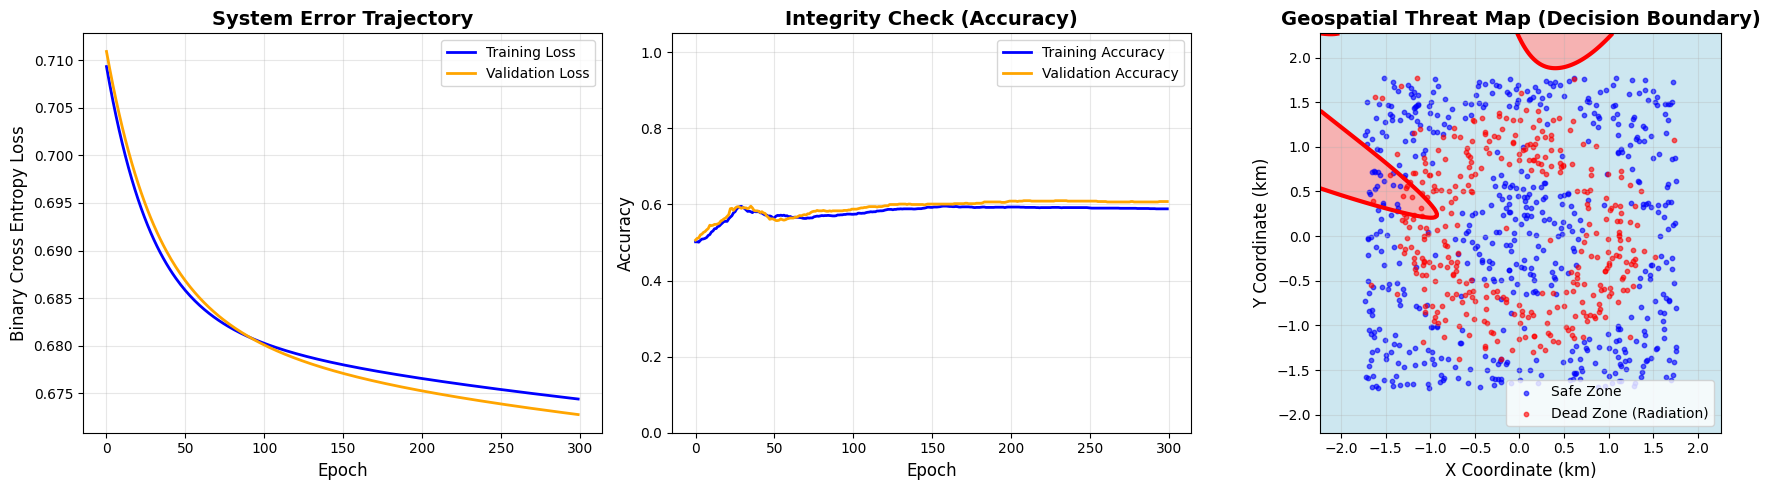

In [13]:
# ==============================================================================
# Code from here. Best of luckk :)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42
)
print(f"Training Set: {X_train.shape}, Validation Set: {X_test.shape}")

LEARNING_RATE = 0.01
EPOCHS = 300
HIDDEN_NEURONS = 16


# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Convert to tensors
X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# initializing weights
torch.manual_seed(GROUP_NUMBER)
w1 = torch.randn(2, HIDDEN_NEURONS, requires_grad=True)
w1.data *= np.sqrt(2.0 / 2)
b1 = torch.zeros(HIDDEN_NEURONS, requires_grad=True)

w2 = torch.randn(HIDDEN_NEURONS, HIDDEN_NEURONS, requires_grad=True)
w2.data *= np.sqrt(2.0 / HIDDEN_NEURONS)
b2 = torch.zeros(HIDDEN_NEURONS, requires_grad=True)

w3 = torch.randn(HIDDEN_NEURONS, HIDDEN_NEURONS, requires_grad=True)
w3.data *= np.sqrt(2.0 / HIDDEN_NEURONS)
b3 = torch.zeros(HIDDEN_NEURONS, requires_grad=True)

w4 = torch.randn(HIDDEN_NEURONS, 1, requires_grad=True)
w4.data *= np.sqrt(2.0 / HIDDEN_NEURONS)
b4 = torch.zeros(1, requires_grad=True)

print(f"Layer 1 : W {w1.shape}, b {b1.shape}")
print(f"Layer 2 : W {w2.shape}, b {b2.shape}")
print(f"Layer 3 : W {w3.shape}, b {b3.shape}")
print(f"Layer 4 : W {w4.shape}, b {b4.shape}")


# Training Loop

train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(EPOCHS):
    #  Forward Pass
    z1 = torch.matmul(X_train, w1) + b1
    a1 = torch.tanh(z1)
    z2 = torch.matmul(a1, w2) + b2
    a2 = torch.tanh(z2)
    z3 = torch.matmul(a2, w3) + b3
    a3 = torch.tanh(z3)
    z4 = torch.matmul(a3, w4) + b4
    a4 = torch.sigmoid(z4)

    train_pred = torch.clamp(a4, 1e-7, 1 - 1e-7)
    loss = -(y_train*torch.log(train_pred) + (1-y_train)*torch.log(1-train_pred)).mean()
    train_losses.append(loss.item())

    binary_preds = (train_pred >= 0.5).float()
    correct = (binary_preds == y_train).sum().item()
    train_acc.append(correct / len(y_train))

    # Backprop
    loss.backward()
    with torch.no_grad():
        w1 -= LEARNING_RATE * w1.grad
        b1 -= LEARNING_RATE * b1.grad
        w2 -= LEARNING_RATE * w2.grad
        b2 -= LEARNING_RATE * b2.grad
        w3 -= LEARNING_RATE * w3.grad
        b3 -= LEARNING_RATE * b3.grad
        w4 -= LEARNING_RATE * w4.grad
        b4 -= LEARNING_RATE * b4.grad
        w1.grad.zero_()
        b1.grad.zero_()
        w2.grad.zero_()
        b2.grad.zero_()
        w3.grad.zero_()
        b3.grad.zero_()
        w4.grad.zero_()
        b4.grad.zero_()

    # Validation
    z1_val = torch.matmul(X_test, w1) + b1
    a1_val = torch.tanh(z1_val)
    z2_val = torch.matmul(a1_val, w2) + b2
    a2_val = torch.tanh(z2_val)
    z3_val = torch.matmul(a2_val, w3) + b3
    a3_val = torch.tanh(z3_val)
    z4_val = torch.matmul(a3_val, w4) + b4
    a4_val = torch.sigmoid(z4_val)

    val_pred = torch.clamp(a4_val, 1e-7, 1 - 1e-7)
    val_loss = -(y_test*torch.log(val_pred) + (1-y_test)*torch.log(1-val_pred)).mean()
    val_losses.append(val_loss.item())

    binary_preds_val = (val_pred >= 0.5).float()
    correct_val = (binary_preds_val == y_test).sum().item()
    val_acc.append(correct_val / len(y_test))

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | "
              f"Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f} | "
              f"Train Acc: {train_acc[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}")


# # activation functions
# def relu(x):
#     return torch.clamp(x, min=0)

# def sigmoid(x):
#     return 1 / (1 + torch.exp(-x))

# # forward pass

# def forward(X):
#     z1 = X @ W1 + b1
#     a1 = relu(z1)

#     z2 = a1 @ W2 + b2
#     a2 = relu(z2)

#     z3 = a2 @ W3 + b3
#     a3 = relu(z3)

#     z4 = a3 @ W4 + b4
#     y_hat = sigmoid(z4)

#     return y_hat

# # binary cross entropy
# def bce_loss(y_hat, y):
#     eps = 1e-7
#     y_hat = torch.clamp(y_hat, eps, 1 - eps)
#     loss = -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))
#     return loss.mean()


# # accuracy
# def accuracy(y_hat, y):
#     preds = (y_hat >= 0.5).float()
#     return (preds == y).float().mean()

# Final Metrics

final_train_acc = train_acc[-1]
final_val_acc = val_acc[-1]
final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]

print(f"Training Accuracy:   {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss:       {final_train_loss:.4f}")
print(f"Validation Loss:     {final_val_loss:.4f}")

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#  Loss Curve
axes[0].plot(train_losses, label='Training Loss', color='blue', linewidth=2)
axes[0].plot(val_losses, label='Validation Loss', color='orange', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Binary Cross Entropy Loss', fontsize=12)
axes[0].set_title('System Error Trajectory', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

#  Accuracy Curve
axes[1].plot(train_acc, label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(val_acc, label='Validation Accuracy', color='orange', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Integrity Check (Accuracy)', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1.05])
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

# Decision Boundary
ax3 = axes[2]
x_min, x_max = X_test[:, 0].min() - 0.5, X_test[:, 0].max() + 0.5
y_min, y_max = X_test[:, 1].min() - 0.5, X_test[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

# Manual forward pass on grid points
with torch.no_grad():
    z1_g = torch.matmul(grid_tensor, w1) + b1
    a1_g = torch.tanh(z1_g)
    z2_g = torch.matmul(a1_g, w2) + b2
    a2_g = torch.tanh(z2_g)
    z3_g = torch.matmul(a2_g, w3) + b3
    a3_g = torch.tanh(z3_g)
    z4_g = torch.matmul(a3_g, w4) + b4
    a4_g = torch.sigmoid(z4_g)
    grid_predictions = a4_g.numpy().reshape(xx.shape)

# Contour plot
contours = ax3.contour(xx, yy, grid_predictions, levels=[0.5], colors='red', linewidths=3)
contourf = ax3.contourf(xx, yy, grid_predictions, levels=[0, 0.5, 1], colors=['lightblue', 'lightcoral'], alpha=0.6)

# Overlay test points
X_test_np = X_test.numpy()
y_test_np = y_test.numpy()
ax3.scatter(X_test_np[y_test_np.flatten()==0, 0], X_test_np[y_test_np.flatten()==0, 1],
            c='blue', s=10, label='Safe Zone', alpha=0.6)
ax3.scatter(X_test_np[y_test_np.flatten()==1, 0], X_test_np[y_test_np.flatten()==1, 1],
            c='red', s=10, label='Dead Zone (Radiation)', alpha=0.6)

ax3.set_xlabel('X Coordinate (km)', fontsize=12)
ax3.set_ylabel('Y Coordinate (km)', fontsize=12)
ax3.set_title('Geospatial Threat Map (Decision Boundary)', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)
ax3.set_aspect('equal')

plt.tight_layout()
plt.savefig('GDC_Dashboard_Group5', dpi=150, bbox_inches='tight')
plt.show()

# ==============================================================================